In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

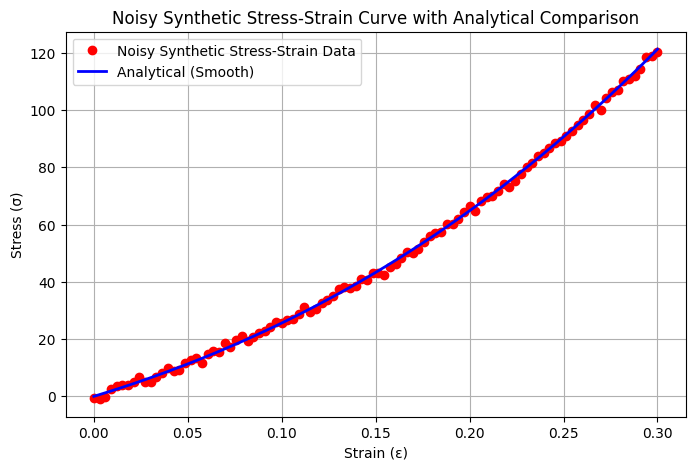

In [6]:

E_modulus = 200  # Elastic modulus (MPa)
C1, C2 = 500, 600  # Nonlinear coefficients
noise_level = 1 

def generate_nonlinear_elastic_data(epsilon_values, E, C1, C2, noise_level):
    sigma = E * epsilon_values + C1 * epsilon_values ** 2 + C2 * epsilon_values ** 3
    noise = noise_level * np.random.randn(*epsilon_values.shape)
    return sigma + noise

epsilon_train = np.linspace(0, 0.3, 100).reshape(-1, 1).astype(np.float32)
sigma_train = generate_nonlinear_elastic_data(epsilon_train, E_modulus, C1, C2, noise_level).astype(np.float32)
plt.figure(figsize=(8, 5))
plt.plot(epsilon_train, sigma_train, 'ro', label='Noisy Synthetic Stress-Strain Data')


epsilon_analytical = np.linspace(0, 0.3, 100).reshape(-1, 1).astype(np.float32)
sigma_analytical = E_modulus * epsilon_analytical + C1 * epsilon_analytical ** 2 + C2 * epsilon_analytical ** 3
plt.plot(epsilon_analytical, sigma_analytical, 'b-', linewidth=2, label='Analytical (Smooth)')

# Labels and title
plt.xlabel('Strain (ε)')
plt.ylabel('Stress (σ)')
plt.title('Noisy Synthetic Stress-Strain Curve with Analytical Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Convert to PyTorch tensors
epsilon_train_tensor = torch.tensor(epsilon_train, requires_grad=False)
sigma_train_tensor = torch.tensor(sigma_train)


In [7]:
class BlackBoxNN(nn.Module):
    def __init__(self, hidden_dim, num_hidden_layers):
        super(BlackBoxNN, self).__init__()
        self.input_layer = nn.Linear(1, hidden_dim)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers)]
        )
        
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, epsilon):
        x = torch.relu(self.input_layer(epsilon))
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        
        return self.output_layer(x)


Epoch 0, Loss: 4148.4752734375
Epoch 100, Loss: 1067.88212890625
Epoch 200, Loss: 885.281826171875
Epoch 300, Loss: 355.7477783203125
Epoch 400, Loss: 21.142251281738282
Epoch 500, Loss: 12.120026702880859
Epoch 600, Loss: 2.931823272705078
Epoch 700, Loss: 1.817695484161377
Epoch 800, Loss: 1.8337434387207032
Epoch 900, Loss: 1.4912126636505127
Epoch 1000, Loss: 1.4343441581726075
Epoch 1100, Loss: 1.1441646909713745
Epoch 1200, Loss: 1.1467607307434082
Epoch 1300, Loss: 1.0703263759613038
Epoch 1400, Loss: 0.9460305786132812
Epoch 1500, Loss: 1.0657410335540771
Epoch 1600, Loss: 0.9017878484725952
Epoch 1700, Loss: 0.8942567443847657
Epoch 1800, Loss: 0.9237299156188965
Epoch 1900, Loss: 0.9800072956085205
Epoch 2000, Loss: 1.0770544242858886
Epoch 2100, Loss: 0.9623890209197998
Epoch 2200, Loss: 0.8547996830940247
Epoch 2300, Loss: 0.8866510438919067
Epoch 2400, Loss: 0.9619758892059326
Epoch 2500, Loss: 1.134560604095459
Epoch 2600, Loss: 0.9965111064910889
Epoch 2700, Loss: 1.0102

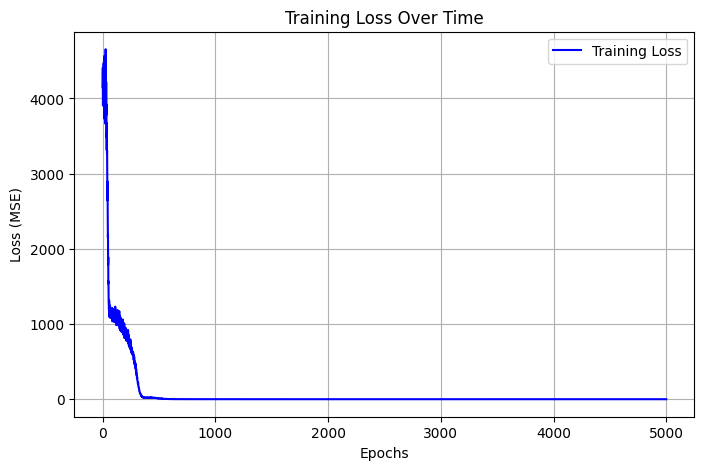

In [8]:

hidden_dim = 10 
num_hidden_layers = 3  
net = BlackBoxNN(hidden_dim, num_hidden_layers)
loss_fn = nn.MSELoss()
epochs = 5000
lr = 1e-3
batch_size = 16  
optimizer = optim.Adam(net.parameters(), lr=lr)
loss_history = []

for epoch in range(epochs):
    permutation = torch.randperm(epsilon_train_tensor.size(0))  # Shuffle the data at each epoch
    
    epoch_loss = 0  
    
    for i in range(0, epsilon_train_tensor.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        epsilon_batch = epsilon_train_tensor[indices]
        sigma_batch = sigma_train_tensor[indices]
        
        optimizer.zero_grad()
        
        pred_stress = net(epsilon_batch)
        
        loss = loss_fn(pred_stress, sigma_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / (epsilon_train_tensor.size(0) / batch_size)
    loss_history.append(avg_epoch_loss)
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {avg_epoch_loss}')

# Save trained model for future use
torch.save(net.state_dict(), 'black_box_nn.pth')

# Visualize the training loss
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), loss_history, 'b-', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

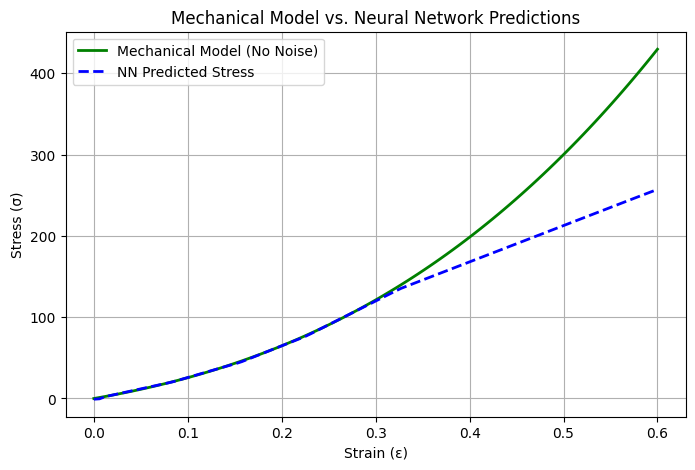

In [9]:
epsilon_test = np.linspace(0, 0.6, 100).reshape(-1, 1).astype(np.float32)
epsilon_test_tensor = torch.tensor(epsilon_test, requires_grad=False)
pred_sigma_test = net(epsilon_test_tensor).detach().numpy()
sigma_mechanical_model = generate_nonlinear_elastic_data(epsilon_test, E_modulus, C1, C2, 0)
plt.figure(figsize=(8, 5))
plt.plot(epsilon_test, sigma_mechanical_model, 'g-', label='Mechanical Model (No Noise)', linewidth=2)
plt.plot(epsilon_test, pred_sigma_test, 'b--', label='NN Predicted Stress', linewidth=2)
plt.xlabel('Strain (ε)')
plt.ylabel('Stress (σ)')
plt.title('Mechanical Model vs. Neural Network Predictions')
plt.legend()
plt.grid(True)
plt.show()
